In [60]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns 

import feature_engineering as FE 

from importlib import reload
reload(FE);

# New feature: Center a window around event dates 


If we want to ask/test: 
"Does a drought mean that the time trace does something particular within some time surrounding it...'

Then we should be able to take any bit of time trace corresponding to a non-event, take the same min/max/median value and see it responds differently. 

We implement this idea as follows:
* First create the values corresponding to the label 'yes there is a drought' by making a bin/window, centered at the drought event. Calculate the max/min or whatever quantity of interest 
* Next, randomly sample the remaining bin centers until no more bin can fit. 

In [53]:
reload(FE)
# --- read data ---- 
DroughtData = pd.read_csv('datasets/Droughts_satelite_and_events.csv')
districts_with_droughts = pd.read_csv('datasets/districts_with_droughts_Uganda_Kenya.csv')
DroughtData.head()

# --- only keep 'relevant' satellite data --- 
reduced_data = FE.reduce_dataset(DroughtData, districts_with_droughts, keep_years=1)


# --- apply window to get new indicators --- 

# troubleshoot = reduced_data[(reduced_data['District']=='ADJUMANI')|(reduced_data['District']=='AMOLATAR')]
window_size=3
fname = 'datasets/Droughts_satelite_and_events_ReducedNegatives_windows_' + str(window_size)+'Months.csv'

window_data = FE.sample_no_replacement_window(reduced_data, window_size)
window_data.to_csv(fname,index=False)



# --- normalize (Z-norm) data ----
fname2 = fname.replace('.csv','') + '_Znormed.csv'
features = []
for column_name in window_data.columns:
    if ('_min' in column_name) or ('_max' in column_name) or ('_med' in column_name):
        if ('SPEI' not in column_name):
            features.append(column_name)
non_features = list(window_data.columns.drop(features))

normed_data = FE.norm_by_district(window_data,features_no_norm=non_features)

normed_data.to_csv(fname2, index=False)

length original data:  39532
length reduced data:  7871


# check correlations 

/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/mklein1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pypl

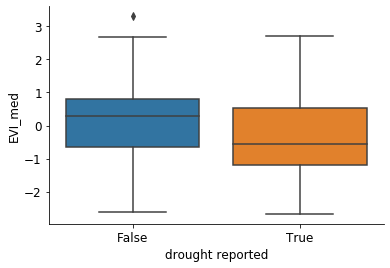

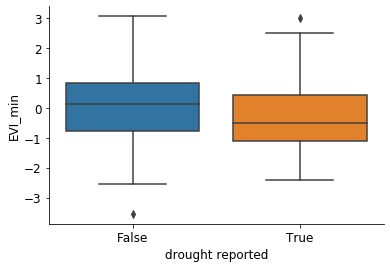

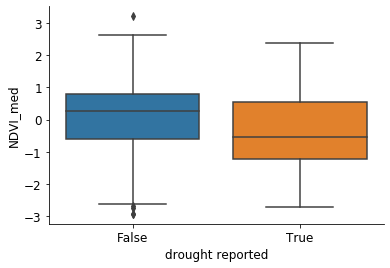

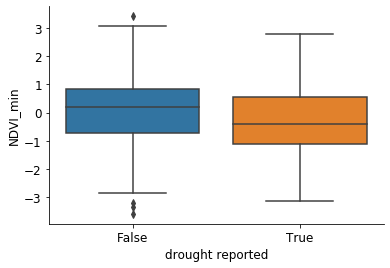

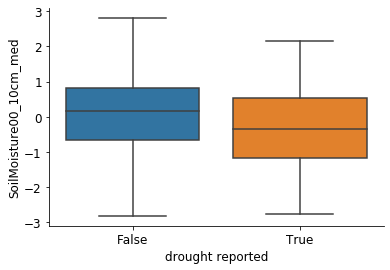

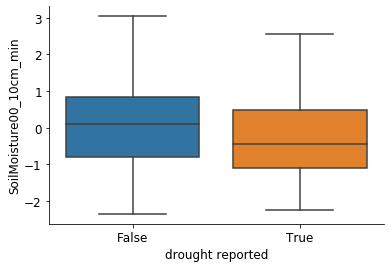

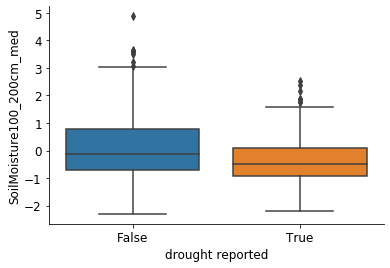

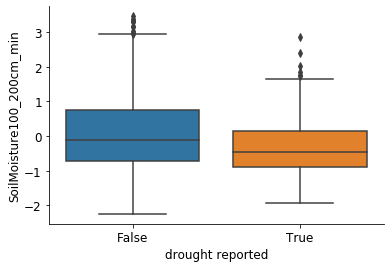

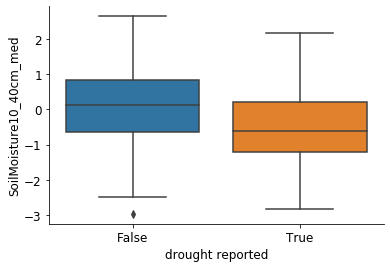

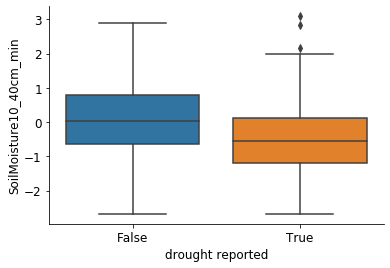

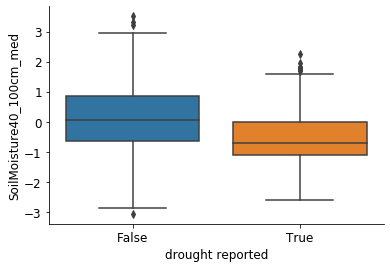

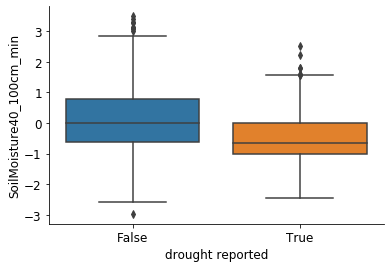

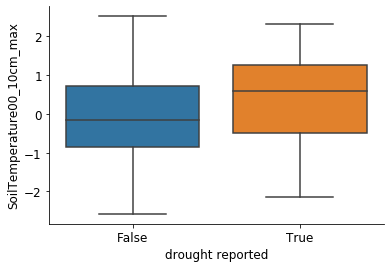

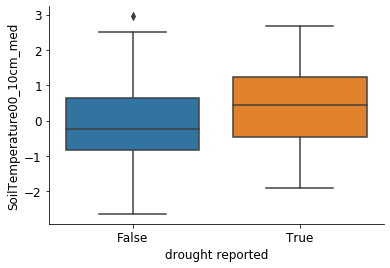

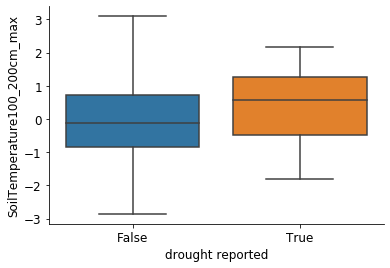

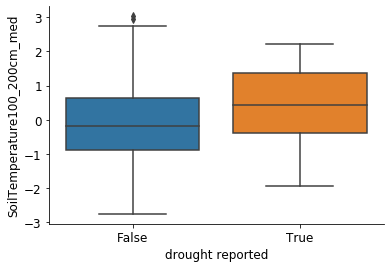

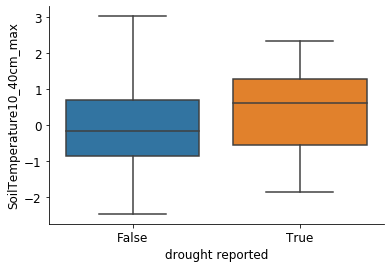

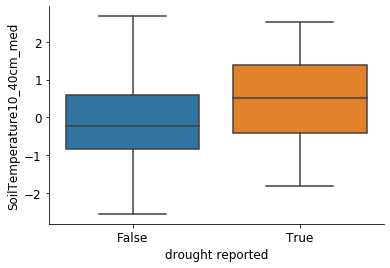

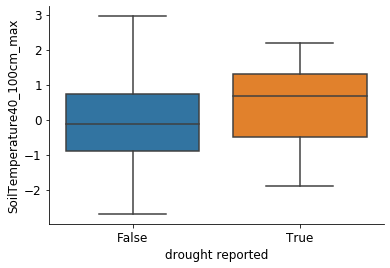

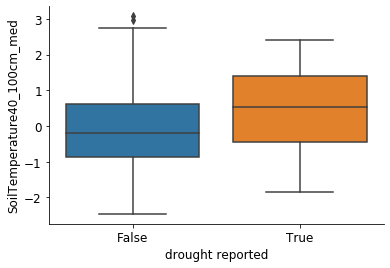

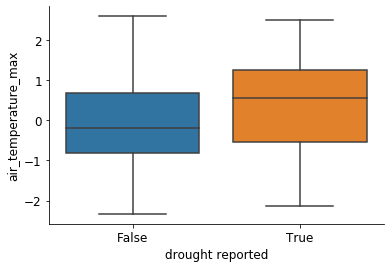

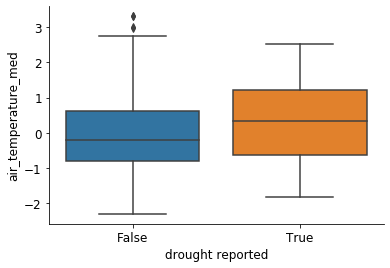

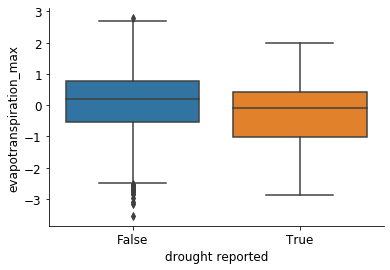

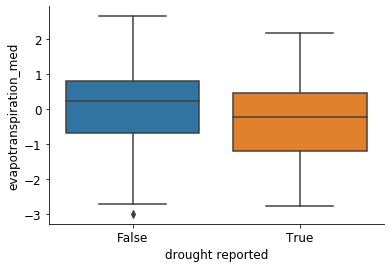

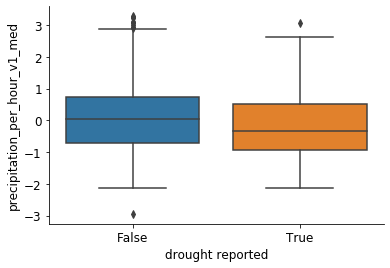

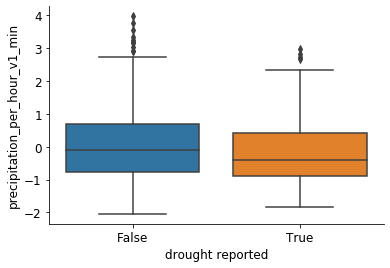

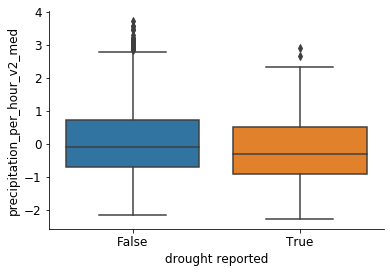

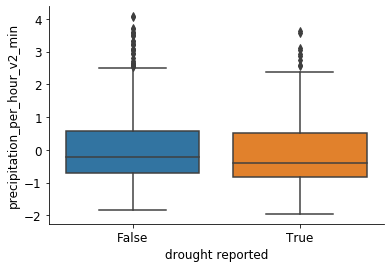

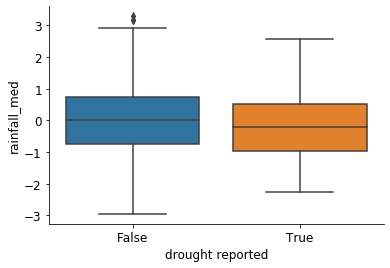

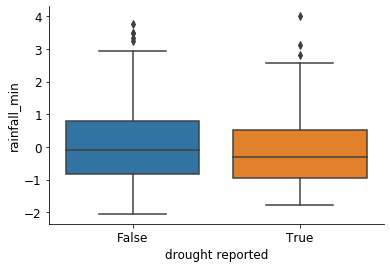

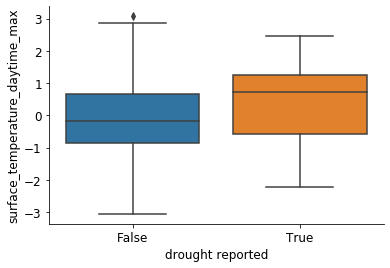

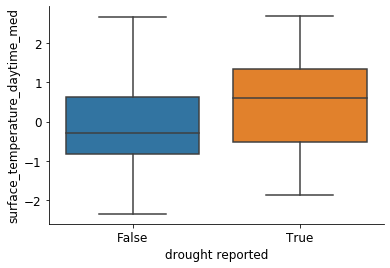

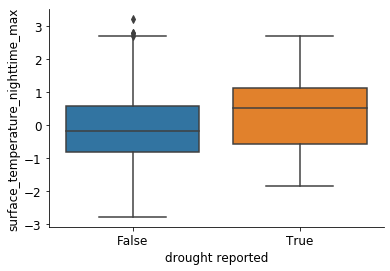

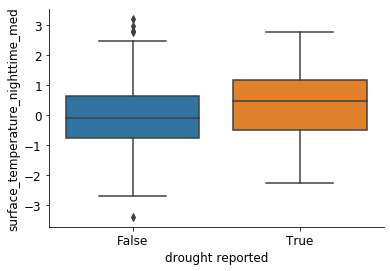

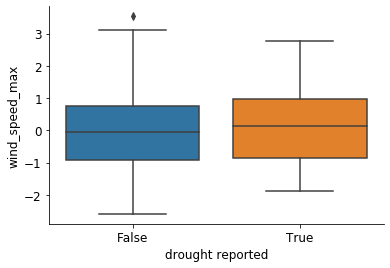

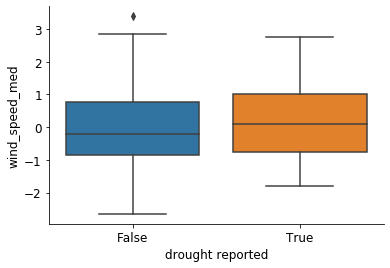

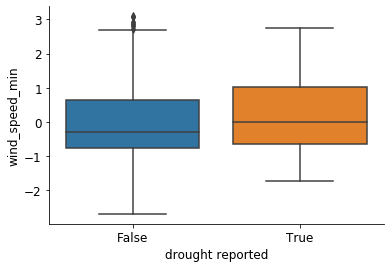

In [65]:
# indicators = list(normed_by_district.columns.drop(['Country','District','date','day','month','year']))

features = []
for column_name in normed_data.columns:
    if ('_min' in column_name) or ('_max' in column_name) or ('_med' in column_name):
        if ('SPEI' not in column_name):
            features.append(column_name)

for var in features:
    plt.figure()
    sns.boxplot(x='drought_reported',y=var,data=normed_data);
    plt.xlabel('drought reported', fontsize=12,color='black')
    plt.ylabel(var, fontsize=12, color="black")
    plt.xticks(rotation=0,fontsize=12, color="black")
    plt.yticks(fontsize=12, color="black");
    sns.despine();

# Implementing the sampling of a window without replacement

In [ ]:
def get_window(data, loc):
    start_index = max(min(data.index), min(data.index) + int(loc - np.floor(0.5*(window_size-1))  ) )
    stop_index  = min(max(data.index), min(data.index) + int(loc + np.floor(0.5*(window_size-1))  ) )
    window_index = list(range(start_index, stop_index + 1))
    return window_index


def windows_available(pool, chosen, window_size):
    # --- list the points not sampled yet---- 
    remaining = [x for x in pool if x not in chosen]
    
    # --- check if a window of desired size can still be centered around remaining points --- 
    available = []
    for loc in remaining:
        start_index = int(loc - np.floor(0.5*(window_size-1)))
        stop_index = int(loc + np.floor(0.5*(window_size-1)))

        if (start_index in remaining) and (stop_index in remaining):
            available.append( loc )
    return available , remaining


def apply_random_window(data, event_locations, window_size):
    '''
    input the data per district. 
    output a set of windows
    '''
    # ---- initialize ---
    available_points = list(data.index)
    chosen_points = []
    windows = []
    
    # --- first get the windows belonging to the events ---- 
    print('points available: ', list(data.index))
    for loc in event_locations:
        new_window = get_window(data, loc)
        windows.append( new_window )
        for i in new_window:
            chosen_points.append(i)
    
    while len(available_points) > 0:
        new_loc = np.random.choice(available_points,replace=False)
        new_window = get_window(data, new_loc)
        windows.append(new_window)
        for i in new_window:
            chosen_points.append(i)

        available_points, remaining = windows_available(pool=list(data.index), chosen=chosen_points,window_size=window_size)

    return windows, remaining


# --- input --- 
event_locations =  [0, 8]
# maybe add automatic check if window size exceeds smallest distance between events. 
# If not, please choose larger window
window_size = 3  


# --- create input data (mock) --- 
data = pd.DataFrame()
data['values'] = np.arange(1,20)

# --- get the windows --- 
windows, remaining = apply_random_window(data, event_locations, window_size)


print('windows: ')
for w in windows:
    print(w)
    
print('\n')
print('remaining data points: ',remaining)

windows 

In [ ]:
window_size = 1

# --- input all the possible indices (per district, so need to ask for it on the fly, cannot use range(len(data))) --- 
pool = list(data.index)

# --- input the already chosen rows of dataframe --- 
chosen = chosen_points 

# --- make list of possible points that can be used as centers of windows ---- 
remaining = [x for x in pool if x not in chosen]

available = []
for loc in remaining:
    start_index = int(loc - np.floor(0.5*(window_size-1)))
    stop_index = int(loc + np.floor(0.5*(window_size-1)))
    
    if (start_index in remaining) and (stop_index in remaining):
        available.append( loc )
        
print(available)

In [26]:
districts_with_droughts['drought_in_district']

0       True
1       True
2      False
3       True
4       True
       ...  
164     True
165     True
166     True
167     True
168     True
Name: drought_in_district, Length: 169, dtype: bool

In [10]:
import time 
for x in range(10):
    print("Progress {:2.1%}".format(x / 10), end="\r")
    time.sleep(1.0)